## Import modules

In [8]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [11]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN'
protein="TNR" #TNR,Agg,WFA,HABP

## Load aligned images from matlab GUI

In [12]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):
        if ("output_classification" in str(filelist[i]))==True:
            if (protein in str(filelist[i]))==True:
                if filelist[i].endswith(".txt"): 
                    if str(filelist[i][:-12]) not in str(results["filename"]):
                        spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                "vglut spot aligned":[],
                "dio spot aligned":[],
                 "sted spot aligned no back":[],
                "vglut spot aligned no back":[],
                "dio spot aligned no back":[],
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[]}
                  
for spot in range(0,len(spots["filename"])):
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)

## Add calculations of mean vglut and ecm intensity, and mean vglut size in the individual spots

In [14]:
for spotno in range(0,len(synapses_results["spots classification filename"])):
    synapses_results["mean ecm intensity sted"][spotno]=np.nanmean(synapses_results["sted spot aligned"][spotno])
    synapses_results["mean ecm intensity sted noback"][spotno]=np.nanmean(synapses_results["sted spot aligned no back"][spotno])
    synapses_results["mean vglut intensity sted"][spotno]=np.nanmean(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut intensity sted noback"][spotno]=np.nanmean(synapses_results["vglut spot aligned no back"][spotno])
    synapses_results["mean vglut size (sum of pixels)"][spotno]=np.sum(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut size (sum of pixels) from noback"][spotno]=np.sum(synapses_results["vglut spot aligned no back"][spotno])

    #bg subtraction
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)

## Make average images

In [15]:
df=pd.DataFrame(synapses_results)

## Plot a random spot image

Text(0.5, 1.0, 'dio around synapse spot')

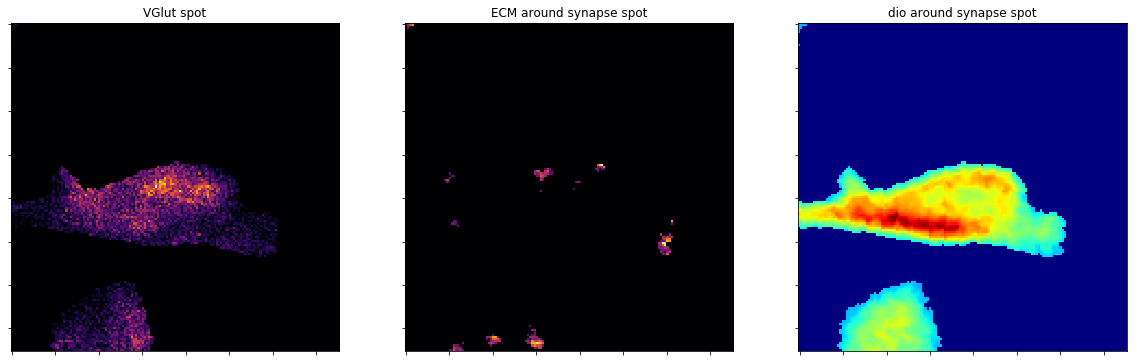

In [19]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df["vglut spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('VGlut spot')
fig.add_subplot(132)
plt.imshow(df["sted spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot')
fig.add_subplot(133)
plt.imshow(df["dio spot aligned"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot')

## Add radial average

In [20]:
## radial_average version 2 - define function
def radial_average(image):
    import numpy as np
    import scipy
    from scipy import ndimage
    import matplotlib.pyplot as plt

    f = image
    sx, sy = f.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    r = np.hypot(X - sx/2, Y - sy/2)
    rbin = (20* r/r.max()).astype(np.int) ##30 rings --> r-
    radial_mean = ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))
    return radial_mean

##add radial average
df['radial_average_ecm']=''
df['radial_average_ecm_bgsubtracted']=''
df['radial_average_dio']=''
df['radial_average_vglut']=''
df['radial_average_vglut_bgsubtracted']=''
for i in range(0,len(df['radial_average_ecm_bgsubtracted'])):
    df['radial_average_ecm_bgsubtracted'][i]=radial_average(df["ecm intensity sted, bg subtracted"][i])
    df['radial_average_ecm'][i]=radial_average(df["sted spot aligned"][i])
    df['radial_average_vglut'][i]=radial_average(df["vglut spot aligned"][i])
    df['radial_average_vglut_bgsubtracted'][i]=radial_average(df["vglut intensity sted, bg subtracted"][i])
    df['radial_average_dio'][i]=radial_average(df["dio spot aligned"][i])

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning

## Add meaningful columns to the df

In [22]:
#make df, which also contains column names for plotting (drug, condition)
df['Time']='None'
df.loc[df['exp condition'].str.contains('12hr'), 'Time'] = '12hrs'
df.loc[df['exp condition'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['exp condition'].str.contains('Control'), 'Time'] = 'Unblocked Control'
df.loc[df['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'

In [1]:
len(df[df["Condition"]=="12hr + Bic"])

NameError: name 'deepcopy' is not defined

In [85]:
df.columns

Index(['spots classification filename', 'sted spot', 'vglut spot', 'dio spot',
       'sted spot aligned', 'vglut spot aligned', 'dio spot aligned',
       'sted spot aligned no back', 'vglut spot aligned no back',
       'dio spot aligned no back', 'Exp name', 'Cell number',
       'unique id (expname_cell number)', 'classification',
       'mean ecm intensity sted', 'ecm intensity sted, bg subtracted',
       'mean ecm intensity sted noback',
       'ecm intensity sted noback bg subtracted', 'mean vglut intensity sted',
       'vglut intensity sted, bg subtracted',
       'mean vglut intensity sted noback',
       'vglut intensity sted noback bg subtracted',
       'mean vglut size (sum of pixels)',
       'mean vglut size (sum of pixels) from noback', 'exp condition',
       'radial_average_ecm', 'radial_average_ecm_bgsubtracted',
       'radial_average_dio', 'radial_average_vglut',
       'radial_average_vglut_bgsubtracted', 'Time', 'Drug', 'Condition',
       'mean ecm intensity s

In [88]:
len(dfcellsgroups)

53

## Add mean of intensity

In [45]:
df["mean ecm intensity sted, bg subtracted"]=np.nan
df["mean vglut intensity sted, bg subtracted"]=np.nan
for i in range(0,len(df)):
    df["mean ecm intensity sted, bg subtracted"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted"][i]=df["vglut intensity sted, bg subtracted"][i].mean()

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Is there a correlation between bouton intensity and dendrite intensity on the same cells?

In [95]:
np.unique(df["classification"])

array([array(1.), array(2.), array(3.)], dtype=object)

In [96]:
df["unique id (expname_cell number)"].unique()

array(['0225_03_01', '0225_03_02', '0225_03_03', '0225_03_04',
       '0225_03_05', '0225_04_01', '0225_04_02', '0225_04_03',
       '0225_04_04', '0225_04_05', '0225_05_01', '0225_05_02',
       '0225_05_03', '0225_05_04', '0225_05_05', '0225_06_01',
       '0225_06_02', '0225_06_03', '0225_06_04', '0225_01_06',
       '0225_01_01', '0225_01_02', '0225_01_03', '0225_01_04',
       '0225_01_05', '0302_05_01', '0302_05_02', '0302_05_03',
       '0302_05_04', '0302_05_05', '0302_06_01', '0302_06_02',
       '0302_06_04', '0302_01_01', '0302_01_02', '0302_01_03',
       '0302_01_05', '0302_01_06', '0302_02_01', '0302_02_02',
       '0302_02_03', '0302_02_04', '0302_02_05', '0302_03_01',
       '0302_03_02', '0302_03_03', '0302_03_04', '0302_03_05',
       '0302_04_01', '0302_04_02', '0302_04_03', '0302_04_04',
       '0302_04_05'], dtype=object)

In [97]:
dict_cells={"expname":[],"cell id":[],"boutons mean int":[],"dendrites mean int":[],
           "mushrooms mean int":[],"flats mean int":[]}
for cell in df["unique id (expname_cell number)"].unique():
    dfcell=df[df["unique id (expname_cell number)"]==cell].reset_index()
    dict_cells["expname"].append(dfcell["Exp name"][0])
    dict_cells["cell id"].append(cell)
    dfcellboutons=dfcell[dfcell["classification"]==3.]
    dfcellmushrooms=dfcell[dfcell["classification"]==1.]
    dfcellflats=dfcell[dfcell["classification"]==2.]
    dfcellpostsynapses=dfcell[dfcell["classification"]!=3.]
    dict_cells["dendrites mean int"].append(dfcellpostsynapses["mean ecm intensity sted, bg subtracted"].mean())
    dict_cells["boutons mean int"].append(dfcellboutons["mean ecm intensity sted, bg subtracted"].mean())
    dict_cells["mushrooms mean int"].append(dfcellmushrooms["mean ecm intensity sted, bg subtracted"].mean())
    dict_cells["flats mean int"].append(dfcellflats["mean ecm intensity sted, bg subtracted"].mean())




              
              

In [98]:
dfcells=pd.DataFrame(dict_cells)

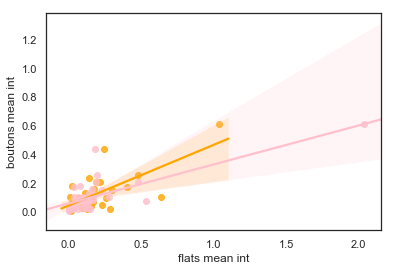

In [130]:
#g=sns.regplot(y="boutons mean int",x="dendrites mean int",data=dfcells,color='blue')
g=sns.regplot(y="boutons mean int",x="mushrooms mean int",data=dfcells,color='orange')
g=sns.regplot(y="boutons mean int",x="flats mean int",data=dfcells,color='pink')
#plt.xscale('log')
#plt.xscale('log2')
#plt.xlim([-0.01,0.5])
#plt.ylim([-0.01,0.04])

In [91]:
#make df grouped by cells
dfcellsgroups=df.groupby("unique id (expname_cell number)","classification")

ValueError: No axis named classification for object type <class 'type'>

In [147]:
df["new class"]=''
for i in range(0,len(df)):
    df["new class"][i]=df["classification"][i].astype(str)

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [160]:
df["classification"][0].astype(list)

array(3.0, dtype=object)

In [163]:
df_newepitopes.groupby('classification').mean()

TypeError: unhashable type: 'numpy.ndarray'

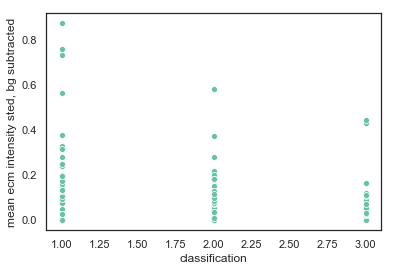

In [162]:
sns.scatterplot(x="classification",y="mean ecm intensity sted, bg subtracted",data=df_allepitopes)

## Look only at DMSO, separate into mushrooms and flats for further analysis

In [149]:
df_newepitopes=df[df["Condition"]=="None"]
df_allepitopes=df[df["Condition"]!="None"]

In [46]:
dfdmso=deepcopy(df[df["Condition"]=="12hr"])
dfmushrooms_dmso=dfdmso[dfdmso["classification"]==1.0]
dfflats_dmso=dfdmso[dfdmso["classification"]==2.0]

In [136]:
dfmushrooms_allblocked=df[(df["classification"]==1.0)&(df["Condition"]!="None")]
dfflats_allblocked=df[(df["classification"]==2.0)&(df["Condition"]!="None")]
dfmushrooms_unblocked=df[(df["classification"]==1.0)&(df["Condition"]=="None")]
dfflats_unblocked=df[(df["classification"]==2.0)&(df["Condition"]=="None")]





In [164]:

newdf={"class":[],"mean ecm":[]}
newdf["class"].append("mushroom")
newdf["mean ecm"].append(dfmushrooms_allblocked["mean ecm intensity sted, bg subtracted"].mean())
newdf["class"].append("flat")
newdf["mean ecm"].append(dfflats_allblocked["mean ecm intensity sted, bg subtracted"].mean())

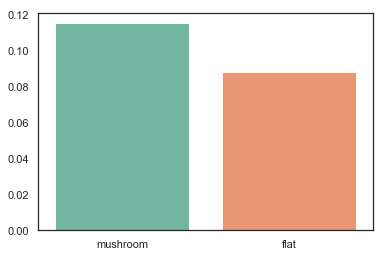

In [166]:
sns.barplot(x="class",y="mean ecm",data=newdf)

In [167]:

newdf={"class":[],"mean ecm":[]}
newdf["class"].append("mushroom")
newdf["mean ecm"].append(dfmushrooms_unblocked["mean ecm intensity sted, bg subtracted"].mean())
newdf["class"].append("flat")
newdf["mean ecm"].append(dfflats_unblocked["mean ecm intensity sted, bg subtracted"].mean())

In [ ]:
## sns.barplot(x="class",y="mean ecm",data=newdf)

In [60]:
type(dfdmso["classification"].values)

numpy.ndarray

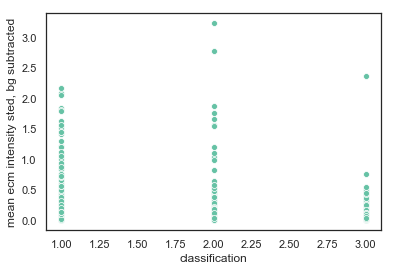

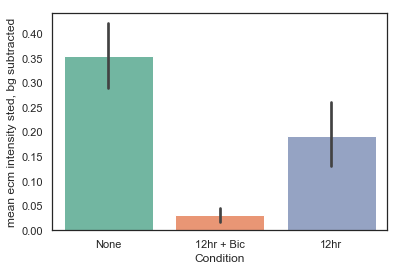

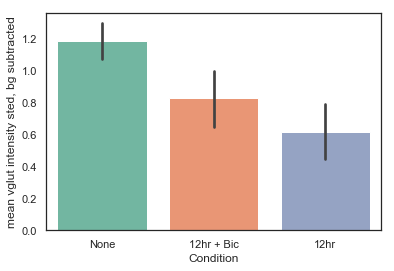

In [78]:
plt.figure()
sns.scatterplot(x="classification",y="mean ecm intensity sted, bg subtracted",
           data=df)
plt.figure()
sns.barplot(x="Condition",y="mean ecm intensity sted, bg subtracted",
           data=dfmushrooms)
plt.figure()
sns.barplot(x="Condition",y="mean vglut intensity sted, bg subtracted",
           data=dfflats)

## Correlation mean ECM to vGlut int, separately for mushrooms and flats

<Figure size 432x288 with 0 Axes>

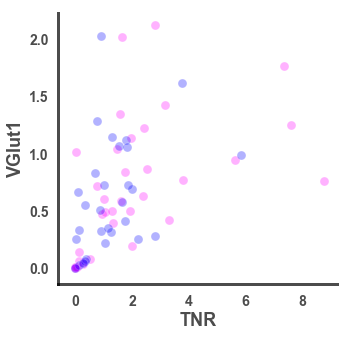

In [50]:
from matplotlib import ticker
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.despine()
sns.set_palette("Set2")

fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean ecm intensity sted, bg subtracted",
                  y="mean vglut intensity sted, bg subtracted",
                  data=dfmushrooms_dmso,
               color="magenta",alpha=0.3,s=80)
g=sns.scatterplot(x="mean ecm intensity sted, bg subtracted",
                  y="mean vglut intensity sted, bg subtracted",
                  data=dfflats_dmso,
               color="blue",alpha=0.3,s=80)
#g.set_xscale('log')
plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)


g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')
g.set_ylabel('VGlut1',color='black',alpha=.7,fontsize=18,weight='bold')
g.set_xlabel('TNR',color='black',alpha=.7,fontsize=18,weight='bold')
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

scale_x=1/10
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
g.xaxis.set_major_formatter(ticks_x)




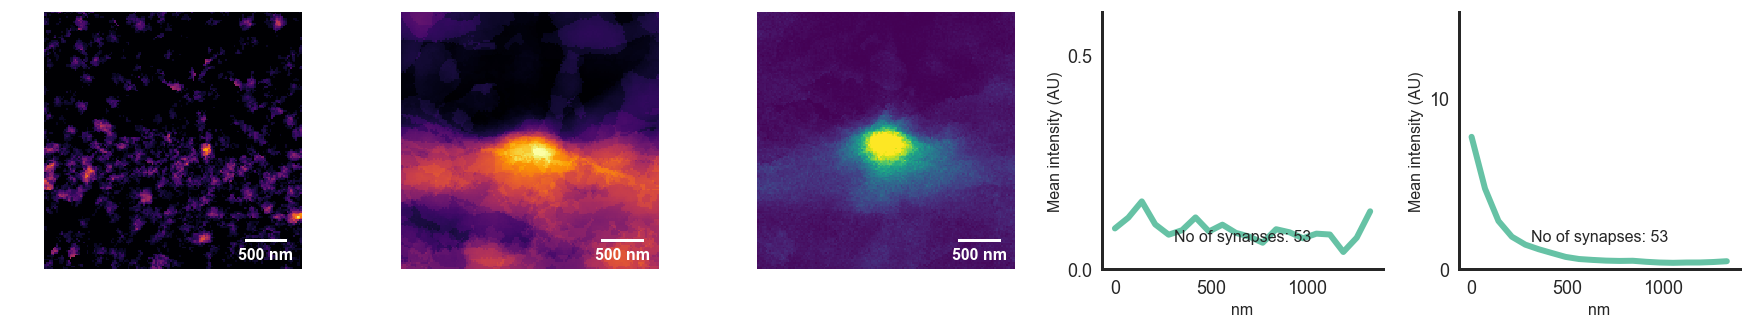

In [140]:
df2plot=dfflats_allblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(151)
plt.imshow(df2plot["sted spot aligned"].mean()
           ,cmap='inferno',
           vmin=dfdmso["sted spot aligned"].mean().min(),
           vmax=np.max(dfdmso["sted spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

fig.add_subplot(152)
plt.imshow(df2plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(dfdmso["dio spot aligned"].mean()),
           vmax=np.max(dfdmso["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

fig.add_subplot(153)
plt.imshow(df2plot["vglut spot aligned"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
           vmax=np.max(dfdmso["vglut spot aligned"].mean()))
numbersynapses=len(dfdmso["vglut spot aligned"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

ax=fig.add_subplot(154)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_ecm"].values.mean(),linewidth=6)
numbersynapses=len(df2plot["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.ylim([0,0.6])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
#plt.subplots_adjust(right=1.2)

ax=fig.add_subplot(155)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_vglut"].values.mean(),linewidth=6)
numbersynapses=len(df2plot["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.ylim([0,15])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
#plt.subplots_adjust(right=1.2)
plt.tight_layout()

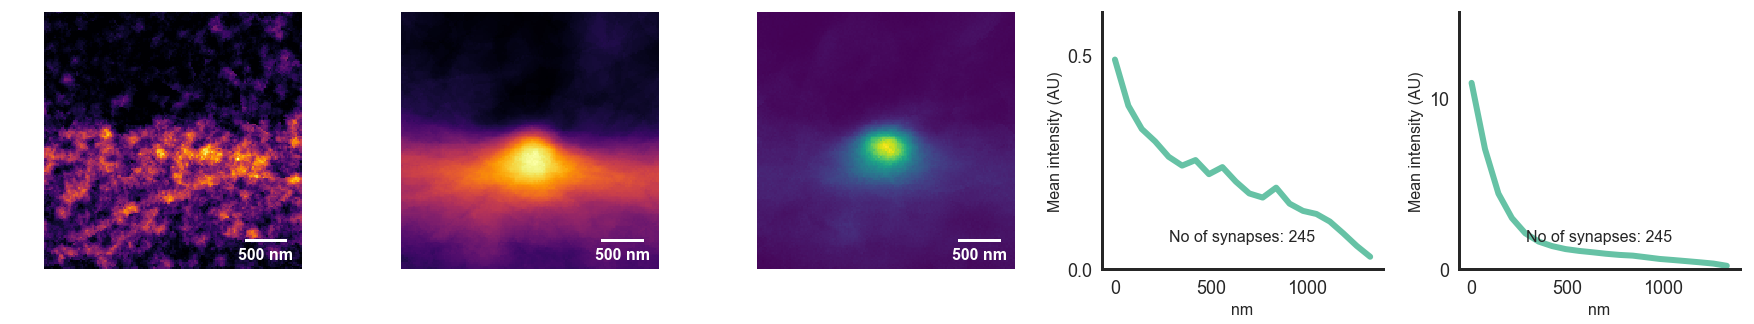

In [132]:
df2plot=dfflats
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(151)
plt.imshow(df2plot["sted spot aligned"].mean()
           ,cmap='inferno',
           vmin=df2plot["sted spot aligned"].mean().min(),
           vmax=np.max(df2plot["sted spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

fig.add_subplot(152)
plt.imshow(df2plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["dio spot aligned"].mean()),
           vmax=np.max(df2plot["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

fig.add_subplot(153)
plt.imshow(df2plot["vglut spot aligned"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["vglut spot aligned"].mean()))
numbersynapses=len(df2plot["vglut spot aligned"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

ax=fig.add_subplot(154)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_ecm"].values.mean(),linewidth=6)
numbersynapses=len(df2plot["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.ylim([0,0.6])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
#plt.subplots_adjust(right=1.2)

ax=fig.add_subplot(155)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_vglut"].values.mean(),linewidth=6)
numbersynapses=len(df2plot["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.ylim([0,15])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
#plt.subplots_adjust(right=1.2)
plt.tight_layout()

In [39]:
sns.barplo§at("ecm")

KeyError: 'mean ecm intensity'

### Plot average ECM and synapse images for treated, for every synapse intensity bin

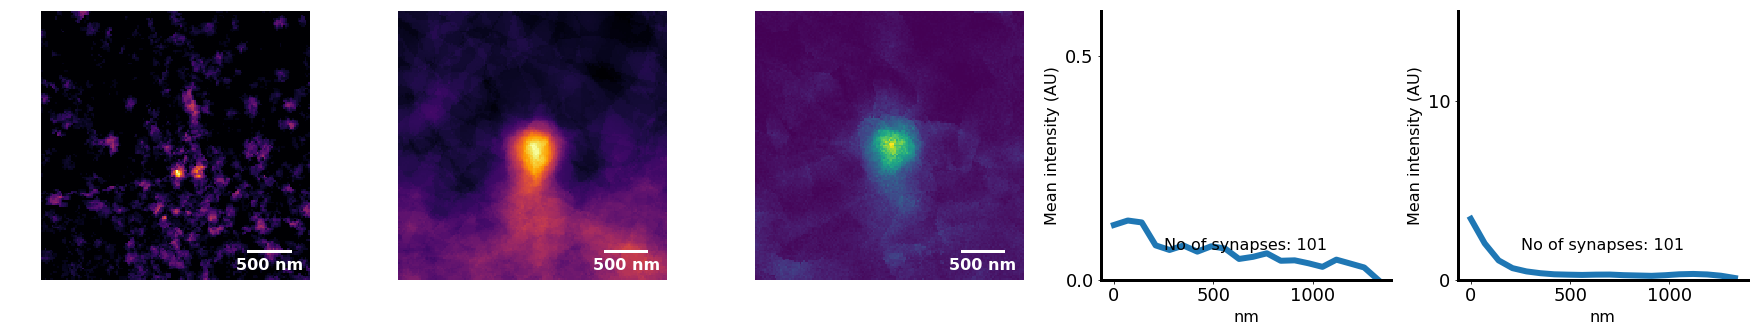

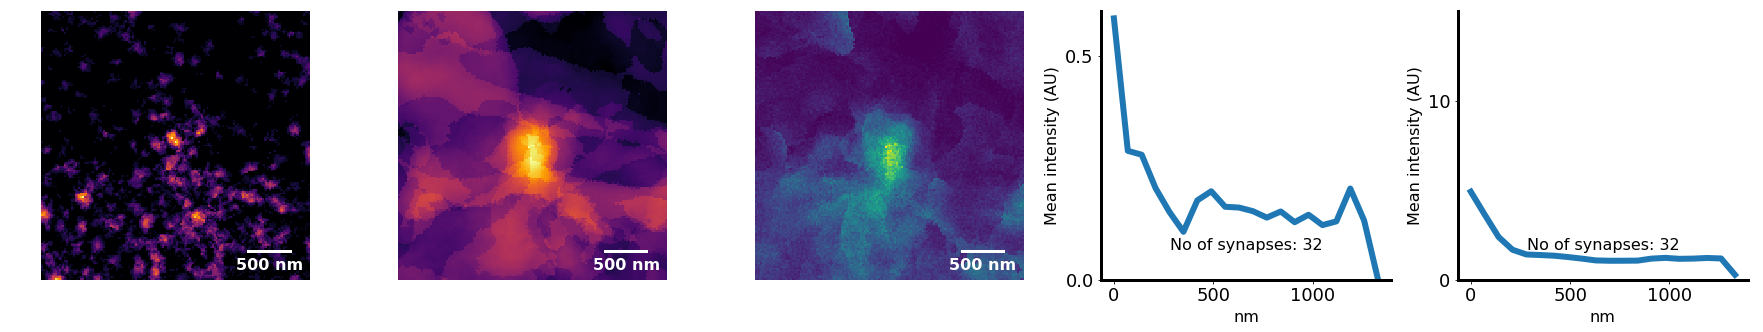

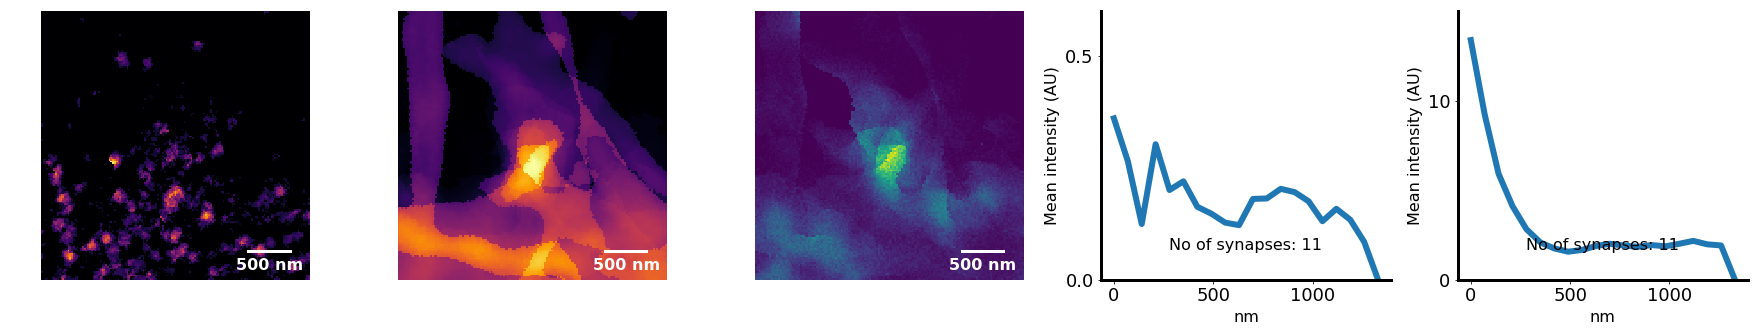

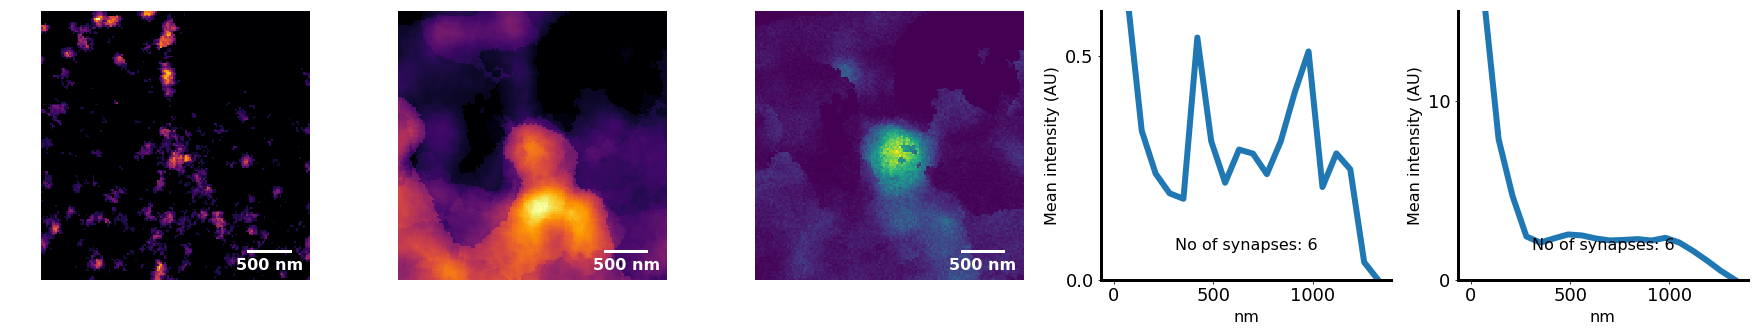

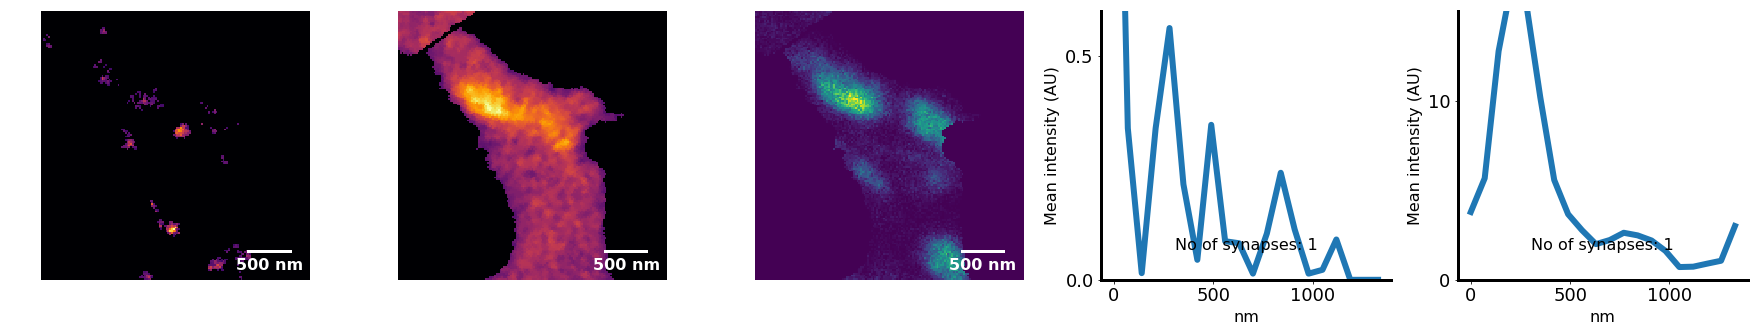

In [26]:
df2=dfmushrooms #1-mushroom, 2-flat, 3-bouton
for i in range(5):
    
    df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 5 = brightest)'].astype(int)==i)&(df2["Time"]!="Unblocked Control")]
    
    fig=plt.figure(figsize=(25,5))
    plt.axis('off')
    #plt.title(str(i))
    fig.add_subplot(151)
    plt.imshow(df2plot["sted spot aligned"].mean()
               ,cmap='inferno',
               vmin=df2plot["sted spot aligned"].mean().min(),
               vmax=np.max(df2plot["sted spot aligned"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    fig.add_subplot(152)
    plt.imshow(df2plot["dio spot aligned"].mean()
               ,cmap='inferno',
               vmin=np.min(df2plot["dio spot aligned"].mean()),
               vmax=np.max(df2plot["dio spot aligned"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    fig.add_subplot(153)
    plt.imshow(df2plot["vglut spot aligned"].mean(),
               cmap='viridis',
               vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
               vmax=np.max(df2plot["vglut spot aligned"].mean()))
    numbersynapses=len(df2plot["vglut spot aligned"])
    #plt.title('Only controls - no. synapses: '+str(numbersynapses))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    ax=fig.add_subplot(154)
    plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_ecm"].values.mean(),linewidth=6)
    numbersynapses=len(df2plot["vglut spot aligned"]) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.ylim([0,0.6])
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
        horizontalalignment='center',
            verticalalignment='bottom',size=16,
        transform=ax.transAxes)
    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=5)
    plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
    plt.xlabel('nm',size=16,labelpad=5)
    #plt.subplots_adjust(right=1.2)
    
    ax=fig.add_subplot(155)
    plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_vglut"].values.mean(),linewidth=6)
    numbersynapses=len(df2plot["vglut spot aligned"]) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.ylim([0,15])
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
        horizontalalignment='center',
            verticalalignment='bottom',size=16,
        transform=ax.transAxes)
    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=5)
    plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
    plt.xlabel('nm',size=16,labelpad=5)
    #plt.subplots_adjust(right=1.2)
    plt.tight_layout()

### Look at several examples of synapse spots for treated conditions

In [19]:
df2plot_noctrl=df2[(df2["Time"]!="Unblocked Control")]
df2plot_noctrl=df2plot_noctrl.reset_index()

### Plot all treated and all unblocked controls  - Bic versus DMSO

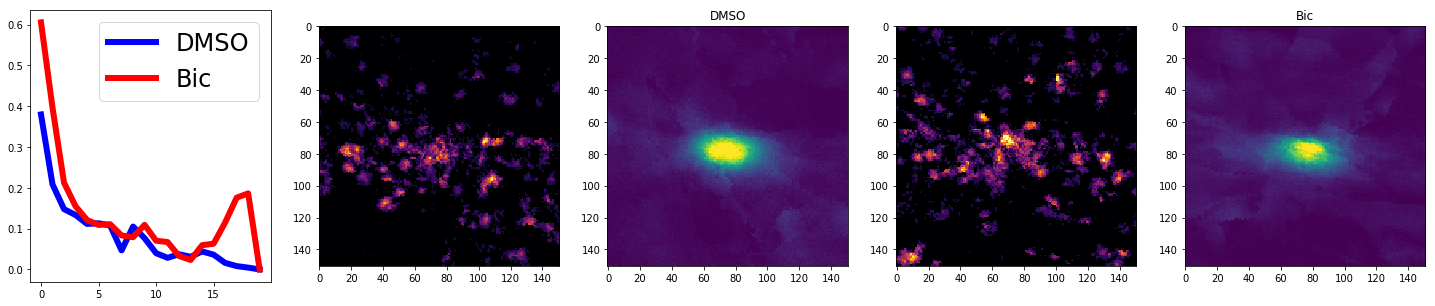

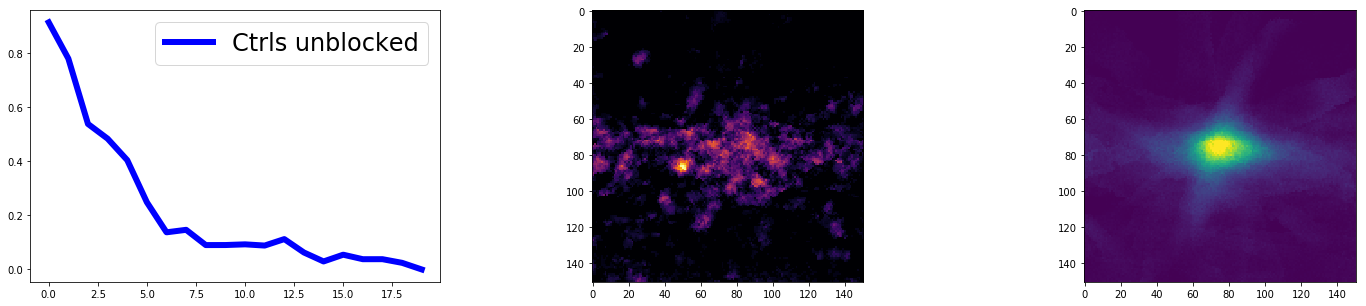

In [20]:
i=-1
df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 5 = brightest)'].astype(int)>i)&(df2["Time"]!="Unblocked Control")]

bic=df2plot[(df2plot["Drug"]=="Bic")]
dmso=df2plot[(df2plot["Drug"]=="DMSO")]

fig=plt.figure(figsize=(25,5))
fig.add_subplot(151)
plt.plot(dmso["radial_average_ecm"].values.mean(),linewidth=6.0,color='blue')
plt.plot(bic["radial_average_ecm"].mean(),linewidth=6.0,color='red')
plt.gca().set(adjustable='box')
plt.legend(['DMSO','Bic'],fontsize=24)
fig.add_subplot(152)
average_imageb=sum(dmso["sted spot aligned"])/len(dmso["sted spot aligned"])
plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

fig.add_subplot(153)
average_imagebsynapse=sum(dmso["vglut spot aligned"])/len(dmso["vglut spot aligned"])
plt.imshow(average_imagebsynapse,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.8*average_imagebsynapse.max())
plt.title('DMSO')

fig.add_subplot(154)
average_imagec=sum(bic["sted spot aligned"])/len(bic["sted spot aligned"])
plt.imshow(average_imagec,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

fig.add_subplot(155)
average_imagebsynapseb=sum(bic["vglut spot aligned"])/len(bic["vglut spot aligned"])
plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
plt.title('Bic')

###plot only control
df2plot_ctrl=df2[(df2['Synapse brightness scale (0 = dimmest, 5 = brightest)'].astype(int)>i)&(df2["Time"]=="Unblocked Control")]

fig=plt.figure(figsize=(25,5))
fig.add_subplot(131)
plt.plot(df2plot_ctrl["radial_average_ecm"].values.mean(),linewidth=6.0,color='blue')
plt.gca().set(adjustable='box')
plt.legend(['Ctrls unblocked'],fontsize=24)
fig.add_subplot(132)
average_imageb=sum(df2plot_ctrl["sted spot aligned"])/len(df2plot_ctrl["sted spot aligned"])
plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())
fig.add_subplot(133)
average_imagebsynapseb=sum(df2plot_ctrl["vglut spot aligned"])/len(df2plot_ctrl["vglut spot aligned"])
plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())


In [ ]:
df2=dfflats
df2plot=df2[df2["Time"]!="Unblocked Control"]
df2plotcontrols=df2[df2["Time"]=="Unblocked Control"]
df2plot_bic=df2plot[df2plot["Drug"]=="Bic"]
df2plot_dmso=df2plot[df2plot["Drug"]=="DMSO"]
#load control images§a

fig=plt.figure(figsize=(15,6))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(231)
plt.imshow(df2plot_dmso["sted spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["sted spot aligned"].mean()),
           vmax=np.max(df2plot["sted spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.ylabel('DMSO',size=18,weight='bold')
plt.axis('off')
fig.add_subplot(232)
plt.imshow(df2plot_dmso["vglut spot aligned"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["vglut spot aligned"].mean()),
           vmax=np.max(df2plot["vglut spot aligned"].mean()))
numbersynapses=len(df2plot_dmso["vglut spot aligned"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.axis('off')
#plt.title(str(i))
fig.add_subplot(234)
plt.imshow(df2plot_bic["sted spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["sted spot aligned"].mean()),
           vmax=np.max(df2plot["sted spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.ylabel('Bic',size=18,weight='bold')

plt.axis('off')
fig.add_subplot(235)
plt.imshow(df2plot_bic["vglut spot aligned"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["vglut spot aligned"].mean()),
           vmax=np.max(df2plot["vglut spot aligned"].mean()))
numbersynapses=len(df2plot_bic["vglut spot aligned"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

ax=fig.add_subplot(144)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot_dmso["radial_average_ecm"].values.mean(),
         linewidth=6,color='lightgreen',alpha=.8)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot_bic["radial_average_ecm"].values.mean(),
         linewidth=6,color='mediumpurple',alpha=.8)


numbersynapses_bic=len(df2plot_bic["vglut spot aligned"]) 
numbersynapses_dmso=len(df2plot_dmso["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.3,'No synapses Bic: '+str(numbersynapses_bic),horizontalalignment='center',verticalalignment='bottom',size=12,transform=ax.transAxes)
ax.text(.5,.4,'No synapses DMSO: '+str(numbersynapses_dmso),horizontalalignment='center',verticalalignment='bottom',size=12,transform=ax.transAxes)


plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
plt.legend(['DMSO','Bic'],frameon=False,fontsize=16,loc=0)
#plt.subplots_adjust(right=1.2)
#plt.tight_layout()

### Plot Bic/DMSO at different timepoints, separate for synapse intensity bins

In [ ]:
for i in range(5):
    df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 5 = brightest)'].astype(int)==i)&(df2["Time"]!="Unblocked Control")]
    for time in df2plot["Time"].unique():
        bic=df2plot[(df2plot["Drug"]=="Bic")&(df2plot["Time"]==time)]
        dmso=df2plot[(df2plot["Drug"]=="DMSO")&(df2plot["Time"]==time)]

        fig=plt.figure(figsize=(25,5))
        fig.add_subplot(151)
        plt.title(str(time)+str(len(df2plot[df2plot["Time"]==time])))
        plt.plot(np.linspace(0,70*20,num=20,endpoint=False),dmso["radial_average_ecm"].values.mean(),
            linewidth=6.0,color='blue')
        plt.plot(np.linspace(0,70*20,num=20,endpoint=False),bic["radial_average_ecm"].values.mean(),
                 linewidth=6.0,color='red')
        plt.gca().set(adjustable='box')
        #plt.xlim([0,2000])
        plt.legend(['DMSO','Bic'],fontsize=24)

        fig.add_subplot(152)
        average_imageb=sum(dmso["sted spot aligned"])/len(dmso["sted spot aligned"])
        plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

        fig.add_subplot(153)
        average_imagebsynapse=sum(dmso["vglut spot aligned"])/len(dmso["vglut spot aligned"])
        plt.imshow(average_imagebsynapse,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
        plt.title('DMSO')

        fig.add_subplot(154)
        average_imagec=sum(bic["sted spot aligned"])/len(bic["sted spot aligned"])
        plt.imshow(average_imagec,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

        fig.add_subplot(155)
        average_imagebsynapseb=sum(bic["vglut spot aligned"])/len(bic["vglut spot aligned"])
        plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
        plt.title('Bic')  

### compare intensities between conditions - synapses and ecm

In [ ]:
df2.columns

In [ ]:
import seaborn as sns
d=df2[df2["exp condition"]!="Ctrl_NoBlocking"]
order=['2hrs_DMSO','2hrs_Bic','4hrs_DMSO','4hrs_Bic','12hrs_DMSO','12hrs_Bic']
plt.figure(figsize=(20,10))
sns.barplot(x="exp condition",y='ecm_around_single_spot_mean_intensity bg subtracted',data=d,order=order)

In [ ]:
df2.columns

### Corellation between TNR intensity and VGlut intensity

In [ ]:
df.columns

In [ ]:
df["classification"]

In [ ]:
df["class"]=df["classification"].astype(str)

In [ ]:
df2plotscat=df2
sns.set_palette("husl")
plt.figure(figsize=(10,10))
#df2.plot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
         #loglog=True,kind='scatter',)
ax=sns.scatterplot(x='mean ecm intensity sted',y='mean vglut intensity sted',hue="class",
                  data=df)
#ax.set(xscale="log", yscale="log")
#ax.set(yscale="log")
#ax.set_xlim([0,0.01])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity Synapse (AU)',size=16,labelpad=5)
plt.xlabel('Mean intensity ECM (AU)',size=16,labelpad=5)
plt.legend(frameon=False,fontsize=16,loc=0)

### Corellation between TNR intensity and VGlut size

In [ ]:
df.columns

In [ ]:
dfcells=df2.groupby('Exp name')

In [ ]:
df["exp condition"].unique()

In [ ]:
dfcells=df.groupby('unique id (expname_cell number)').mean()

In [ ]:
dfcells.head()

In [ ]:
df2plotscat=dfcells
df2plotscat_bic=dfcells[dfcells["Condition_marker"]==2]
df2plotscat_dmso=dfcells[dfcells["Condition_marker"]==1]
sns.set_palette("husl")

plt.figure(figsize=(5,5))
#df2.plot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
         #loglog=True,kind='scatter',)
ax=sns.scatterplot(x='mean ecm intensity sted',y='mean vglut intensity sted',
                  data=df2plotscat_bic)
#ax.set(xscale="log", yscale="log")
ax.set(yscale="log")
ax.set_xlim([0,0.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean Vglut size',size=16,labelpad=5)
plt.xlabel('Mean intensity ECM (AU)',size=16,labelpad=5)
plt.legend(frameon=False,fontsize=16,loc=0)

plt.figure(figsize=(5,5))
#df2.plot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
         #loglog=True,kind='scatter',)
ax=sns.scatterplot(x='mean ecm intensity sted',y='mean vglut intensity sted',
                  data=df2plotscat_dmso)
#ax.set(xscale="log", yscale="log")
ax.set(yscale="log")
ax.set_xlim([0,0.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean Vglut size',size=16,labelpad=5)
plt.xlabel('Mean intensity ECM (AU)',size=16,labelpad=5)
plt.legend(frameon=False,fontsize=16,loc=0)

In [ ]:
dfcopy["classification"]

In [ ]:
np.unique(df["classification"])

In [ ]:
dfcopy=deepcopy(df)

dfcopy["class"]=0
dfcopy.loc[dfcopy['classification']==0.0,'class']=1
dfcopy.loc[dfcopy['classification']==1.0,'class']=2
dfcopy.loc[dfcopy['classification']==2.0,'class']=3

dfcopy["Condition_marker"]=0
dfcopy.loc[dfcopy["exp condition"].str.contains('DMSO'),"Condition_marker"]=1
dfcopy.loc[dfcopy["exp condition"].str.contains('Bic'),"Condition_marker"]=2

dfcells=dfcopy.groupby(['unique id (expname_cell number)','class']).mean()

In [ ]:
dfcells

In [ ]:
dfcells

In [ ]:
df2plotscat=dfcells
sns.set_palette("husl")
plt.figure(figsize=(5,5))
#df2.plot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
         #loglog=True,kind='scatter',)
ax=sns.relplot(x='mean ecm intensity sted',y='mean vglut intensity sted',
                  data=df2plotscat,hue='Condition_marker')
#ax.set(xscale="log", yscale="log")
#ax.set(yscale="log")
#ax.set_xlim([0,0.3])
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_linewidth(3)
#ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean Vglut size',size=16,labelpad=5)
plt.xlabel('Mean intensity ECM (AU)',size=16,labelpad=5)
plt.legend(frameon=False,fontsize=16,loc=0)

## browse individual images

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact



def f(Image_no,Synapse_Intensity_bin):
    
    df2ploty=df2[df2['Synapse mean intensity ordinal bin']==int(Synapse_Intensity_bin)]
    df2ploty=df2ploty.reset_index()
    ii=Image_no
    fig=plt.figure(figsize=(8,4))
    fig.add_subplot(121)
    plt.imshow(df2ploty["ecm_around_single_spot bg subtracted"][ii],
               cmap='inferno'
               ,vmin=1.00*df2ploty["ecm_around_single_spot bg subtracted"][10].min(),
               vmax=0.999*df2ploty["ecm_around_single_spot bg subtracted"][10].max())
    fig.add_subplot(122)
    plt.imshow(df2ploty["original_synapse_at_single_spot bg subtracted"][ii],
               cmap='viridis',vmin=0,vmax=0.03)
               #,vmin=0*df2ploty["original_synapse_at_single_spot bg subtracted"][100].min(),
               #vmax=3*df2ploty["original_synapse_at_single_spot bg subtracted"][100].max())
    

#widgets

Image_no=widgets.IntText(min=0,max=len(df2plot),value=1)
Synapse_Intensity_bin=widgets.IntText(min=0,max=4,value=0)

w=interact(f,Image_no=Image_no,Synapse_Intensity_bin=Synapse_Intensity_bin)





In [ ]:
df3=df2[df2['Synapse mean intensity ordinal bin']==int(1)]
df3.head()

In [ ]:
import seaborn as sns
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys  

In [ ]:
df_means=df[[yvar,xvar]]
#K means Clustering 
def doKmeans(X, nclust=3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(df_means, 3)
kmeans = pd.DataFrame(clust_labels)
df_means.insert((df_means.shape[1]),'kmeans',kmeans)

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(df_means[yvar],df_means[xvar],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('ECM')
ax.set_ylabel('Synapses')

plt.colorbar(scatter)

## image for presenting

In [ ]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
nuclei_image_name=results["filename"][randomno]+" Ch"+str(nuclei_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
nuclei_image=pims.open(nuclei_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(121)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('Tenascin-R (STED)')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(122)
plt.imshow(synapse_image,interpolation='none',cmap='inferno')
plt.title('Synaptotagmin-1')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)




### look at distance of tnr from nearest dapi edge

### load tnr spots masks made by icy wavelet transform

In [ ]:
results["TNR spots mask"]=[]
for i in range(0,len(results["filename"])):
    results["TNR spots mask"].append(np.nan)
for mask in range(0,len(results["filename"])):
    print(results["filename"][mask])
    file_name='/'.join(results["filename"][mask].split('/')[:-1])+'/save/'+results["filename"][mask].split('/')[-1]+' Ch1 {0}.tif.roi.binary.tif'
    tnrmask=pims.open(file_name)[0]
    results["TNR spots mask"][mask]=tnrmask

### calculate mean distance from dapi for each spot:
- for each image:
    - load dapi image, clean and binarize it
    - load tnr spots mask from icy
        - label it 
        - regionprops to find centroids of spots
        - for each spot:
            - find centroid
            - calculate min distance from dapi image
            - append to a new dictionary with spots

In [ ]:
range(0,len[results["filename"]])

In [ ]:
tnr_spots={'filename':[],'exp condition':[],'min distance to dapi edge':[]}
from scipy.spatial import distance
#iterate over images
for im in range(0,len(results["filename"])):
    #load dapi image
    nuclei_channel_no=results["nucleichannelno"][im]
    nuclei_image_name=results["filename"][im]+" Ch"+str(nuclei_channel_no)+" {0}.tif"
    nuclei_image=pims.open(nuclei_image_name)[0]
    # clean and binarize dapi image
    nuclei_image=nuclei_image=ndi.gaussian_filter(nuclei_image,sigma=10)
    nuclei_threshold=skimage.filters.threshold_otsu(nuclei_image)
    nuclei_mask=nuclei_image>nuclei_threshold
    nuclei_mask=ndi.binary_dilation(nuclei_mask,iterations=20)
    nuclei_mask=ndi.binary_erosion(nuclei_mask,iterations=20)
    nuclei_mask=ndi.binary_fill_holes(nuclei_mask)
    #find coordinates of nuclei_mask where it equals 1
    a=np.where(nuclei_mask == 1)
    coordinates_nuclei=np.zeros([len(a[0]),2])
    for i in range(0,len(a[0])):
        coordinates_nuclei[i][0]=a[0][i]
        coordinates_nuclei[i][1]=a[1][i]
    #load tnr spots mask
    tnrmask=results["TNR spots mask"][im]
    #for each spot in tnr mask - find minimum distance to dapi mask
    tnr_labelled,ccnum=ndi.label(tnrmask)
    regions = regionprops(tnr_labelled)
    for props in regions:
        y0, x0 = props.centroid
        X = [(y0, x0)]
        coords = coordinates_nuclei
        mindist=distance.cdist(X, coords, 'euclidean')
        tnr_spots['filename'].append(results["filename"][im])
        tnr_spots["exp condition"].append(results["exp condition"][im])
        tnr_spots["min distance to dapi edge"].append(mindist)

In [ ]:
tnrmask=results["TNR spots mask"][0]
#tnrmask=tnrmask>0
fig=plt.figure(figsize=(12,4))
fig.add_subplot(131)
plt.imshow(ecm_image)
fig.add_subplot(132)
plt.imshow(tnrmask,cmap='gray',interpolation='none')
fig.add_subplot(133)
plt.imshow(nuclei_image)
tnr_labelled,ccnum=ndi.label(tnrmask)